<a href="https://colab.research.google.com/github/FahithKRM/research-customer-feedback/blob/main/research_sep_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install scikit-learn nltk seaborn

# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data (only needs to be run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("Setup Complete!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Setup Complete!


In [2]:
# --- FOR DEMONSTRATION: Create a sample DataFrame ---
# In your actual project, you will load your CSV file here.
data = {
    'text': [
        "This product is amazing! I love it.",
        "Absolutely terrible. It broke after one day.",
        "The screen quality is not good at all.",
        "It's an okay product, not great but not bad either.",
        "Overheating issue is a major problem.",
        "Price is high but the quality is excellent.",
        "I am very disappointed with the purchase.",
        "The speaker is barring and the battery life is poor.",
        "A fantastic device, works perfectly.",
        "The screen is not responsive, which is frustrating."
    ],
    'sentiment': [1, 0, 0, 1, 0, 1, 0, 0, 1, 0] # 1 for Positive, 0 for Negative
}
df = pd.DataFrame(data)

# --- TO USE YOUR OWN DATA (after uploading) ---
# df = pd.read_csv('your_dataset_filename.csv')
# You will need to map your star ratings to binary sentiment.
# For example: 1-2 stars -> 0 (Negative), 4-5 stars -> 1 (Positive).
# df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)
# df = df[['text', 'sentiment']] # Keep only the relevant columns

# --- Data Preprocessing Function ---
# This implements the steps from your presentation [cite: 74, 75]
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and non-ASCII text
    text = re.sub(r'[^a-z\s]', '', text)
    # Lemmatization and stop word removal
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

print("Data after preprocessing:")
print(df.head())

Data after preprocessing:
                                                text  sentiment  \
0                This product is amazing! I love it.          1   
1       Absolutely terrible. It broke after one day.          0   
2             The screen quality is not good at all.          0   
3  It's an okay product, not great but not bad ei...          1   
4              Overheating issue is a major problem.          0   

                          clean_text  
0               product amazing love  
1  absolutely terrible broke one day  
2                screen quality good  
3      okay product great bad either  
4    overheating issue major problem  


In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test_series = train_test_split(
    df['clean_text'], df['sentiment'], test_size=0.3, random_state=42
)

# Convert y_test to a list for easier manipulation later
y_test = y_test_series.tolist()

# Initialize and fit the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Data split and vectorized.")
print("Training set size:", X_train_tfidf.shape[0])
print("Test set size:", X_test_tfidf.shape[0])

Data split and vectorized.
Training set size: 7
Test set size: 3


# **Rule-Based Classifier**

In [4]:
# Define negative keywords and negation patterns
negative_keywords = ['terrible', 'bad', 'poor', 'disappointed', 'broke', 'issue', 'problem', 'not good', 'barring', 'frustrating']
negation_words = ['not', 'never']

def rule_based_classifier(texts):
    predictions = []
    for text in texts:
        text_lower = text.lower()
        is_negative = False
        # Rule: Detect direct negative keywords
        if any(keyword in text_lower for keyword in negative_keywords):
            is_negative = True

        # Rule: Handle simple negations like "not responsive"
        tokens = text_lower.split()
        for i, word in enumerate(tokens):
            if word in negation_words and i + 1 < len(tokens):
                # e.g., "not responsive"
                if tokens[i+1] == "responsive":
                     is_negative = True

        predictions.append(0 if is_negative else 1) # 0 for Negative, 1 for Positive
    return predictions

# Get predictions for the original, unprocessed test text
original_test_texts = df.loc[y_test_series.index]['text'].tolist()
y_pred_rule_based = rule_based_classifier(original_test_texts)

print("Rule-Based Model Predictions:", y_pred_rule_based)

Rule-Based Model Predictions: [1, 0, 1]


# **Machine Learning Classifier (Logistic Regression)**

In [5]:
# Initialize and train the Logistic Regression model
ml_model = LogisticRegression(random_state=42)
ml_model.fit(X_train_tfidf, y_train)

# Get predictions
y_pred_ml = ml_model.predict(X_test_tfidf).tolist()

print("ML Model Predictions:", y_pred_ml)

ML Model Predictions: [0, 0, 0]


# **Hybrid Classifier**

In [6]:
def hybrid_classifier(rule_preds, ml_preds):
    hybrid_preds = []
    for i in range(len(rule_preds)):
        # If the rule-based model predicts Negative (0), trust it.
        # This is a simple "override" strategy.
        if rule_preds[i] == 0:
            hybrid_preds.append(0)
        # Otherwise, use the ML model's prediction.
        else:
            hybrid_preds.append(ml_preds[i])
    return hybrid_preds

y_pred_hybrid = hybrid_classifier(y_pred_rule_based, y_pred_ml)

print("Hybrid Model Predictions:", y_pred_hybrid)

Hybrid Model Predictions: [0, 0, 0]


# **Comparative Evaluation and Visualization**

--- Rule-Based Performance ---
              precision    recall  f1-score   support

Negative (0)       1.00      1.00      1.00         1
Positive (1)       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

--- ML-Based Performance ---
              precision    recall  f1-score   support

Negative (0)       0.33      1.00      0.50         1
Positive (1)       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3

--- Hybrid Model Performance ---
              precision    recall  f1-score   support

Negative (0)       0.33      1.00      0.50         1
Positive (1)       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50  

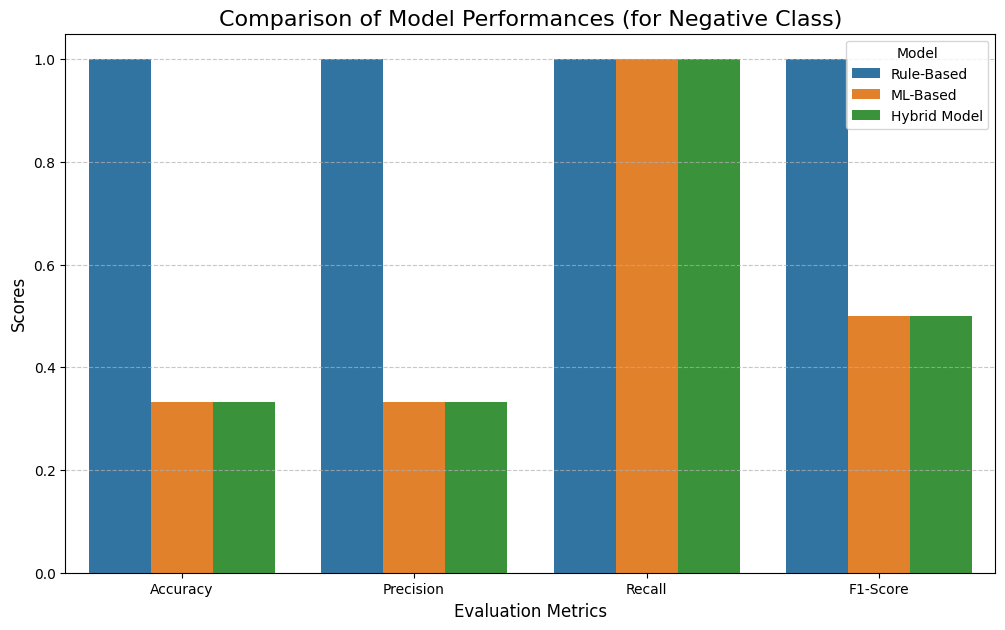


Final Results Table:
          Model  Accuracy  Precision  Recall  F1-Score
0    Rule-Based     1.000      1.000     1.0       1.0
1      ML-Based     0.333      0.333     1.0       0.5
2  Hybrid Model     0.333      0.333     1.0       0.5


In [7]:
# --- Store results in a dictionary for easy plotting ---
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models = {
    'Rule-Based': y_pred_rule_based,
    'ML-Based': y_pred_ml,
    'Hybrid Model': y_pred_hybrid
}

# --- Calculate and print metrics for each model ---
for model_name, y_pred in models.items():
    print(f"--- {model_name} Performance ---")
    print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)'], zero_division=0))

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    # We will calculate precision, recall, f1 for the negative class (label=0) as it's the focus
    results['Precision'].append(precision_score(y_test, y_pred, pos_label=0, zero_division=0))
    results['Recall'].append(recall_score(y_test, y_pred, pos_label=0, zero_division=0))
    results['F1-Score'].append(f1_score(y_test, y_pred, pos_label=0, zero_division=0))

# --- Create a DataFrame for plotting ---
results_df = pd.DataFrame(results)
results_df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# --- Plot the results ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_df_melted)
plt.title('Comparison of Model Performances (for Negative Class)', fontsize=16)
plt.ylim(0, 1.05)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nFinal Results Table:")
print(results_df.round(3))